In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle

import torch
import torch.nn.functional as F
import torch.nn as nn

from torchvision import datasets
from torchvision import transforms

In [2]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O ../Data/tiny-imagenet-200.zip
# !unzip ../Data/tiny-imagenet-200.zip

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset_train = datasets.CIFAR100('../Data/', 
                                           train=True,
                                           transform=transform,
                                           download=True)
dataset_test = datasets.CIFAR100('../Data/', 
                                           train=False,
                                           transform=transform,
                                           download=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=64,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=64,
                                          shuffle=True)

In [5]:
next(iter(dataset_train))[0].shape

torch.Size([3, 32, 32])

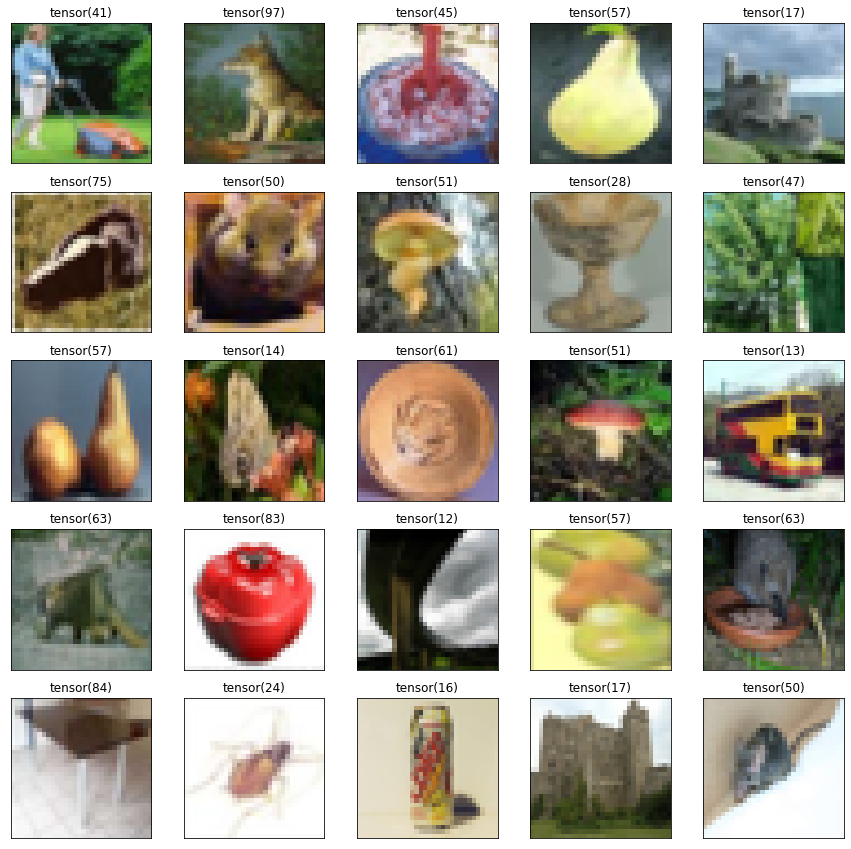

In [6]:
plt.figure(figsize=(15, 15))

for ind, (im, label) in enumerate(train_loader):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(im[0].permute(1, 2, 0).numpy())
    plt.yticks([])
    plt.xticks([])
    plt.title(str(label[0]))

plt.show()

In [7]:
def add_noise(image, noise_distr):
    noise = noise_distr(torch.zeros(image.shape), torch.ones(image.shape)/3)
    return torch.clamp(image + noise.sample(), 0, 1)

In [8]:
noise_distr = torch.distributions.Normal

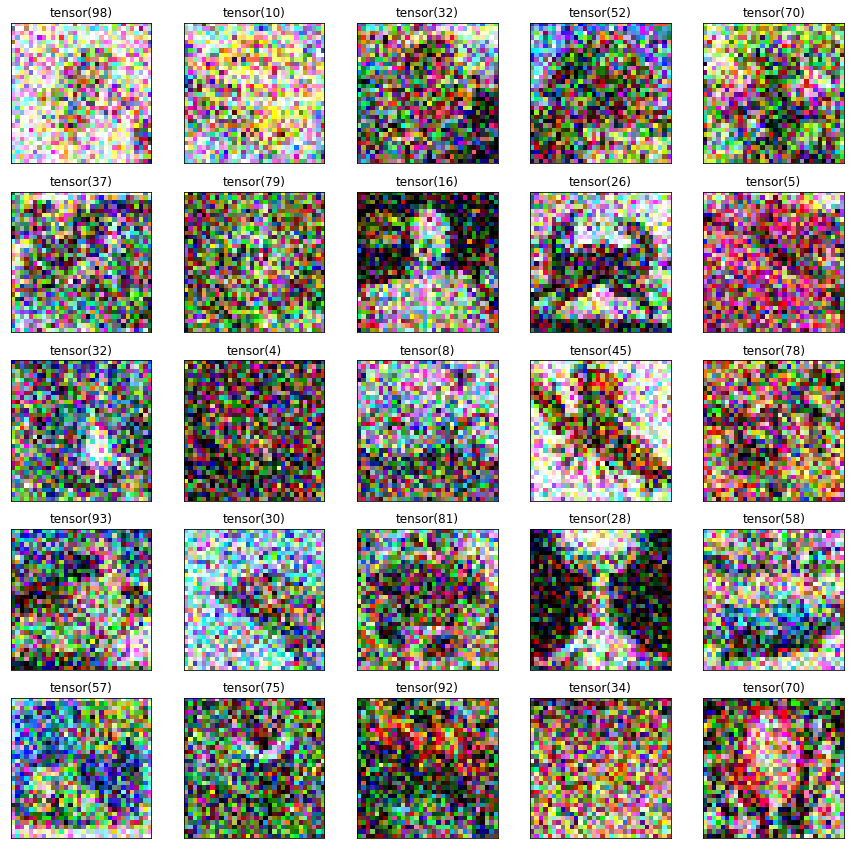

In [9]:
plt.figure(figsize=(15, 15))

for ind, (im, label) in enumerate(train_loader):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(add_noise(im, noise_distr)[0].permute(1, 2, 0).numpy())
    plt.yticks([])
    plt.xticks([])
    plt.title(str(label[0]))

plt.show()

In [10]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)


In [11]:
arr = torch.rand((64, 32, 32, 16), dtype=torch.float32)
k = 8

def pairwise_dist(arr, k):
    """
    arr: torch.Tensor with shape batch x h*w x features
    """
#     arr = arr.view(arr.shape[0], arr.shape[1] * arr.shape[2], -1)
    r_arr = torch.sum(arr * arr, dim=2, keepdim=True) # (B,N,1)
    mul = torch.matmul(arr, arr.permute(0,2,1))         # (B,M,N)
    dist = - (r_arr - 2 * mul + r_arr.permute(0,2,1))       # (B,M,N)
    return dist.topk(k=k, dim=-1)[1]


def batched_index_select(t, dim, inds):
    dummy = inds.unsqueeze(2).expand(inds.size(0), inds.size(1), t.size(2))
    out = t.gather(dim, dummy) # b x e x f
    return out


def get_closest_diff(arr, k):
    """
    arr: torch.Tensor with shape batch x h * w x features
    """
    b, hw, f = arr.shape
#     arr = arr.view(b, h*w, f)
    dists = pairwise_dist(arr, k)
    selected = batched_index_select(arr, 1, dists.view(dists.shape[0], -1)).view(b, hw, k, f)
    diff = arr.unsqueeze(2) - selected
    return diff
    

In [12]:
class NonLocalAggregation(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.k = k
        self.diff_fc = nn.Linear(input_channels, out_channels)
        self.w_self = nn.Linear(input_channels, out_channels)
        self.bias = nn.Parameter(torch.randn(out_channels), requires_grad=True)
        
    def forward(self, x):
        """
        x: torch.Tensor with shape batch x features x h x w
        """
        x = x.permute(0, 2, 3, 1)
        b, h, w, f = x.shape
        x = x.view(b, h*w, f)
        
        closest_graph = get_closest_diff(x, self.k)
        agg_weights = self.diff_fc(closest_graph) # look closer
        agg_self = self.w_self(x)
                
        x_new = torch.mean(agg_weights, dim=-2) + agg_self + self.bias

        return x_new.view(b, h, w, x_new.shape[-1]).permute(0, 3, 1, 2)

In [13]:
class GraphConv(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(input_channels, out_channels, 3, padding=1)
        self.NLA = NonLocalAggregation(k, input_channels, out_channels)
        
    def forward(self, x):
        return torch.mean(torch.stack([self.conv1(x),
                                       self.conv2(x),
                                       self.NLA(x)]), dim=0)

In [14]:
class PreProcessBlock(nn.Module):
    def __init__(self, k, kernel_size, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x

In [15]:
class Residual(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.pipeline = nn.Sequential(
            GraphConv(k, input_channels, input_channels),
            nn.BatchNorm2d(input_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, input_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
        )
        
    def forward(self, x):
        return self.pipeline(x)

In [27]:
loss_mse = nn.MSELoss()

class DNGNN(nn.Module):
    def __init__(self, k, input_channels, hidden_channels):
        super().__init__()
        self.preprocessing_blocks = nn.ModuleList([
            PreProcessBlock(k, 3, input_channels, hidden_channels),
            PreProcessBlock(k, 5, input_channels, hidden_channels),
            PreProcessBlock(k, 7, input_channels, hidden_channels),
        ])
        self.residual_1 = Residual(k, hidden_channels*3, hidden_channels)
        self.residual_2 = Residual(k, hidden_channels, hidden_channels)
        
        self.GC = GraphConv(k, hidden_channels, input_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(hidden_channels*3, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
            nn.Conv2d(hidden_channels, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
        )
        
    def fit_image(self, image):
        processed_image = torch.cat([block(image) for block in self.preprocessing_blocks], dim=1)
        residual_1 = self.residual_1(processed_image)
        result_1 = residual_1 + self.downsample(processed_image)
        residual_2 = self.residual_2(result_1)
        result = residual_2 + result_1
        return [processed_image, residual_1, result, self.GC(result)]
    
    def forward(self, clear_image, noised_image):
        processed_image, residual_1, residual_2, answer = self.fit_image(clear_image)
        n_processed_image, n_residual_1, n_residual_2, n_answer = self.fit_image(noised_image)
        perceptual_loss = loss_mse(processed_image, n_processed_image) + \
            loss_mse(residual_1, n_residual_1) + \
            loss_mse(residual_2, n_residual_2)
        return image + n_answer, perceptual_loss
        

In [28]:
from IPython.display import clear_output

In [29]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(gpu_num))
device

device(type='cuda', index=1)

In [30]:
model = DNGNN(10, 3, 32).cuda(device)
optim = torch.optim.Adam(model.parameters())

In [31]:
loss_mse = nn.MSELoss()
losses = []
psnrs = []

In [32]:
def plot_diff(real, noised, denoised):
    plt.figure(figsize=(15, 15))
    
    for ind, im, noise, denoise in zip(range(1, 13, 3), real[:4], noised[:4], denoised[:4]):
        plt.subplot(4, 3, ind)
        plt.imshow(im)
        plt.yticks([])
        plt.xticks([])
        plt.title('Clear image')
        
        plt.subplot(4, 3, ind+1)
        plt.imshow(noise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Noised image')
        
        plt.subplot(4, 3, ind+2)
        plt.imshow(denoise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Denoised image')


    plt.show()

In [33]:
from tqdm import tqdm

In [36]:
def compute_psnr(image, noised):
    return 10 * np.log10(1/loss_mse(image, noised).item())

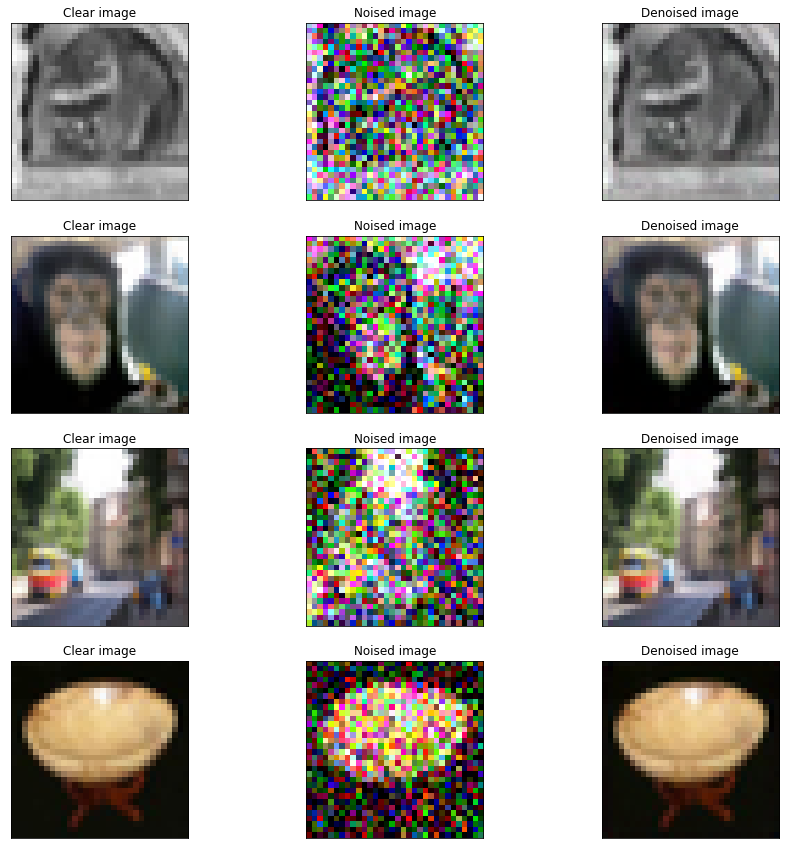

 39%|███▉      | 307/782 [03:20<04:46,  1.66it/s]

In [ ]:
for epoch in range(100):
    for ind, (image, label) in enumerate(tqdm(train_loader)):
        optim.zero_grad()
        image, noise_image = image.cuda(device), add_noise(image, noise_distr).cuda(device)
        denoise_image, perceptual_loss = model(image, noise_image)
        loss = loss_mse(image, denoise_image) + perceptual_loss
        denoise_image = torch.clamp(denoise_image, 0, 1)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        psnrs.append(compute_psnr(image, denoise_image))
        if ind % 50 == 0:
            print(ind, 'MSE: ', losses[-1])
            print(ind, 'PSNR: ', psnrs[-1])
        if ind % 100 == 0:
            clear_output()
            plot_diff(image.cpu().permute(0, 2, 3, 1).data.numpy(),
                      noise_image.cpu().permute(0, 2, 3, 1).data.numpy(),
                      torch.clamp(denoise_image.cpu(), 0, 1).permute(0, 2, 3, 1).data.numpy())

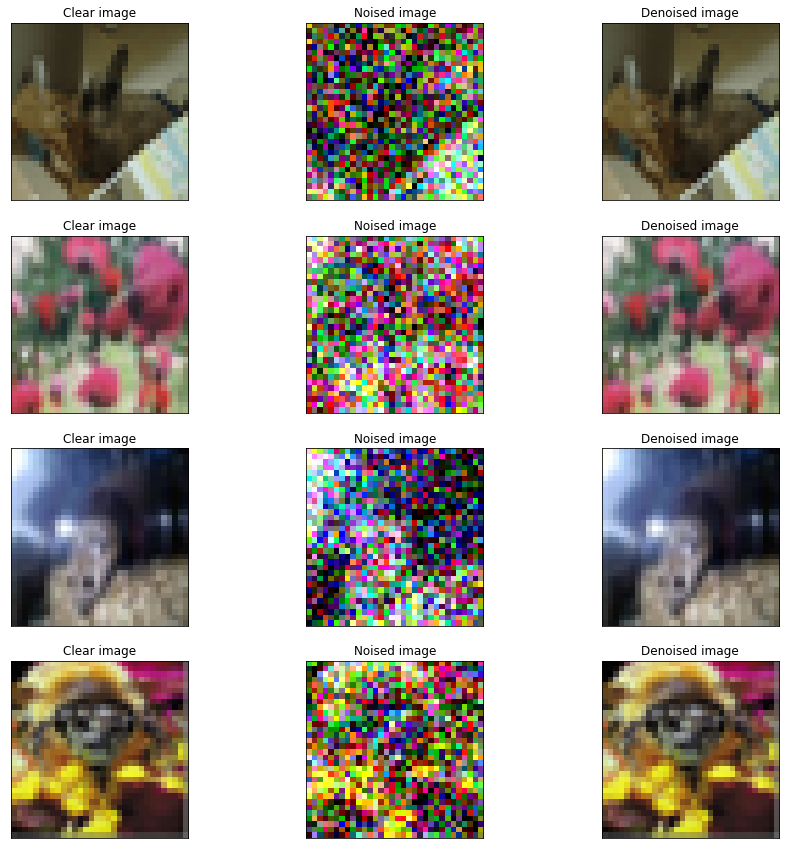



  1%|          | 1/157 [00:01<03:35,  1.38s/it]

  1%|▏         | 2/157 [00:01<02:41,  1.04s/it]

  2%|▏         | 3/157 [00:02<02:14,  1.15it/s]

  3%|▎         | 4/157 [00:02<01:55,  1.32it/s]

  3%|▎         | 5/157 [00:03<01:43,  1.47it/s]

  4%|▍         | 6/157 [00:03<01:33,  1.61it/s]

  4%|▍         | 7/157 [00:04<01:27,  1.71it/s]

  5%|▌         | 8/157 [00:04<01:22,  1.80it/s]

  6%|▌         | 9/157 [00:05<01:18,  1.88it/s]

  6%|▋         | 10/157 [00:05<01:35,  1.55it/s]

KeyboardInterrupt: 

In [26]:
for ind, (image, label) in enumerate(tqdm(test_loader)):
    image, noise_image = image.cuda(device), add_noise(image, noise_distr).cuda(device)
    denoise_image, perceptual_loss = model(image, noise_image)
    if ind % 50 == 0:
        clear_output()
        plot_diff(image.cpu().permute(0, 2, 3, 1).data.numpy(),
                  noise_image.cpu().permute(0, 2, 3, 1).data.numpy(),
                  torch.clamp(denoise_image.cpu(), 0, 1).permute(0, 2, 3, 1).data.numpy())

In [ ]:
nn.MSELoss()

In [ ]:
plt.plot(losses)

In [50]:
# PSNR
# TEST VALIDATION
# PERCEPTUAL LOSS
# SMART LOSSES
# PATCHES FOR BIG IMAGES